# Assignment 3: Logistic regression

**By Vani Seth**

1. Write a program to implement an iterative (e.g., gradient ascent / descent) logistic regression algorithm for binary classification and apply it to the Iris classification data set
2. Iris data set: https://archive.ics.uci.edu/Links to an external site. .
3. Only select data points of two of the three classes (Iris Setosa and Iris Versicolour) to train and test the method
4. Divide data into training and test data randomly according to 80%-20% ratio.
5. Submit your program and execution results including the classification accuracy on the test data in one single document.

### Installing and importing the required libraries

In [8]:
!pip install -q ucimlrepo
!pip install -q scikit-learn
!pip install -q matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

### Loading and preparing the Iris Dataset

In [12]:
# Fetch dataset
iris = fetch_ucirepo(id=53)

# Data (as pandas dataframes)
X_df = iris.data.features
y_df = iris.data.targets

# Combine features and targets for easier filtering
combined_df = pd.concat([X_df, y_df], axis=1)

# Filter for the two selected classes
df_binary = combined_df[combined_df['class'].isin(['Iris-setosa', 'Iris-versicolor'])].copy()

# Map class names to binary labels (0 and 1)
class_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1}
df_binary['class_mapped'] = df_binary['class'].map(class_mapping)

# Get the final numpy arrays for the model
X = df_binary.drop(columns=['class', 'class_mapped']).values
y = df_binary['class_mapped'].values

print(f"Data loaded successfully. Found {len(df_binary)} samples for the two classes.")
print("First 5 rows of the prepared data:")
print(df_binary.head())

Data loaded successfully. Found 100 samples for the two classes.
First 5 rows of the prepared data:
   sepal length  sepal width  petal length  petal width        class  \
0           5.1          3.5           1.4          0.2  Iris-setosa   
1           4.9          3.0           1.4          0.2  Iris-setosa   
2           4.7          3.2           1.3          0.2  Iris-setosa   
3           4.6          3.1           1.5          0.2  Iris-setosa   
4           5.0          3.6           1.4          0.2  Iris-setosa   

   class_mapped  
0             0  
1             0  
2             0  
3             0  
4             0  


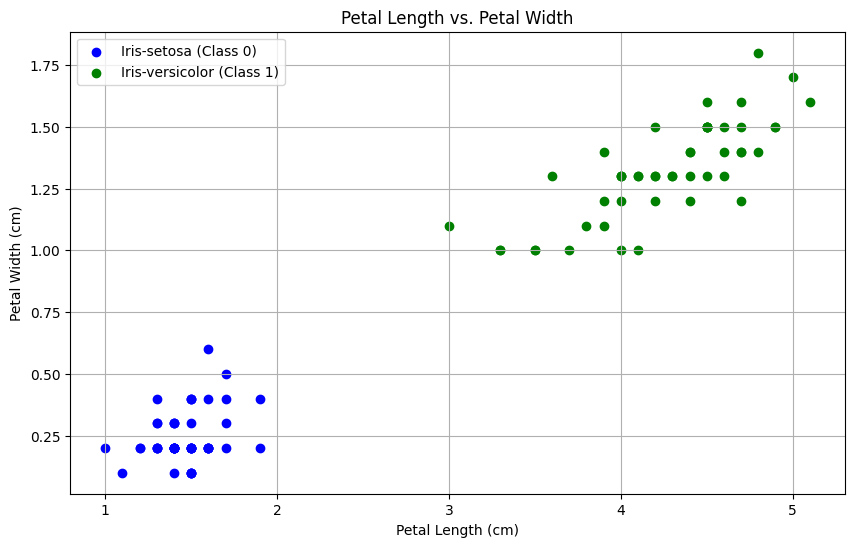

In [13]:
# Visualize the data
plt.figure(figsize=(10, 6))
# Plot Iris-setosa
plt.scatter(X[y == 0][:, 2], X[y == 0][:, 3], color='blue', label='Iris-setosa (Class 0)')
# Plot Iris-versicolor
plt.scatter(X[y == 1][:, 2], X[y == 1][:, 3], color='green', label='Iris-versicolor (Class 1)')

plt.title('Petal Length vs. Petal Width')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.legend()
plt.grid(True)
plt.show()

### Splitting the dataset into 80:20 (train:test)

In [14]:
# Split data into training and testing sets using scikit-learn
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")

Training set size: 80 samples
Test set size: 20 samples


### Defining the Logistic Regression Class

This is a from-scratch implementation of the logistic regression classifier. It uses gradient descent to learn the optimal weights and bias. We've modified the fit method to also record the cost at each iteration, so we can see how the model learns.

In [10]:
class IterativeLogisticRegression:
    """
    A from-scratch implementation of a Logistic Regression classifier using gradient descent.

    Attributes:
        learning_rate (float): The step size for each iteration of gradient descent.
        n_iterations (int): The number of passes over the training dataset.
        weights (np.ndarray): The learned weights (coefficients) for the features.
        bias (float): The learned bias (intercept) term.
        cost_history_ (list): A list of the cost (binary cross-entropy) at each iteration.
    """

    def __init__(self, learning_rate=0.01, n_iterations=1000):
        """Initializes the classifier with given hyperparameters."""
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.cost_history_ = []

    def _sigmoid(self, z):
        """
        The sigmoid activation function.
        """
        # Clip z to avoid overflow in np.exp for large negative values
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Trains the logistic regression model using batch gradient descent and records the cost history.
        """
        n_samples, n_features = X.shape
        # 1. Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.cost_history_ = []

        # 2. Implement Gradient Descent
        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            # Calculate cost (Binary Cross-Entropy) and store it
            # A small epsilon is added to prevent log(0) errors
            epsilon = 1e-9
            cost = (-1 / n_samples) * np.sum(y * np.log(y_predicted + epsilon) + (1 - y) * np.log(1 - y_predicted + epsilon))
            self.cost_history_.append(cost)

            # Calculate gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X, threshold=0.5):
        """
        Makes class predictions for the given input data.
        """
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted_probs = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > threshold else 0 for i in y_predicted_probs]
        return y_predicted_cls


### Defining a Helper Function to calculate the accuracy

In [11]:
def calculate_accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

### Training the Logistic Regression Model

We've created an instance of our `IterativeLogisticRegression` class and call the `fit` method on our training data.

In [15]:
# Hyperparameters
learning_rate = 0.1
n_iterations = 2000

model = IterativeLogisticRegression(learning_rate=learning_rate, n_iterations=n_iterations)
model.fit(X_train, y_train)

print("Training complete.")
print(f"Learned Weights: {model.weights}")
print(f"Learned Bias: {model.bias}")

Training complete.
Learned Weights: [-0.63416777 -2.31815188  3.53682415  1.58267453]
Learned Bias: -0.427972572931216


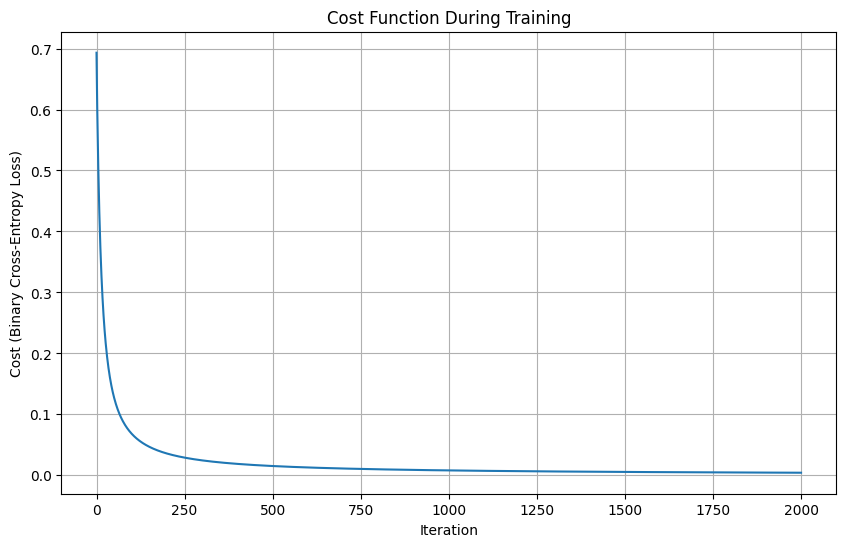

In [16]:
# Plot the cost over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(model.n_iterations), model.cost_history_)
plt.title('Cost Function During Training')
plt.xlabel('Iteration')
plt.ylabel('Cost (Binary Cross-Entropy Loss)')
plt.grid(True)
plt.show()

### Evaluating the model

In [17]:
predictions = model.predict(X_test)
accuracy = calculate_accuracy(y_test, predictions)

print("--- EXECUTION RESULTS ---")
print("\nPredictions on the test set:")
print(f"Predicted Labels: {predictions}")
print(f"Actual Labels:    {y_test.tolist()}")

print("\nClassification Accuracy:")
print(f"The classification accuracy on the test data is: {accuracy * 100:.2f}%")


--- EXECUTION RESULTS ---

Predictions on the test set:
Predicted Labels: [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]
Actual Labels:    [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]

Classification Accuracy:
The classification accuracy on the test data is: 100.00%


We've visualized the decision boundary our model learned. This plot shows the regions where the model predicts class 0 versus class 1. We've overlay the actual test data points to see how well the boundary separates them.

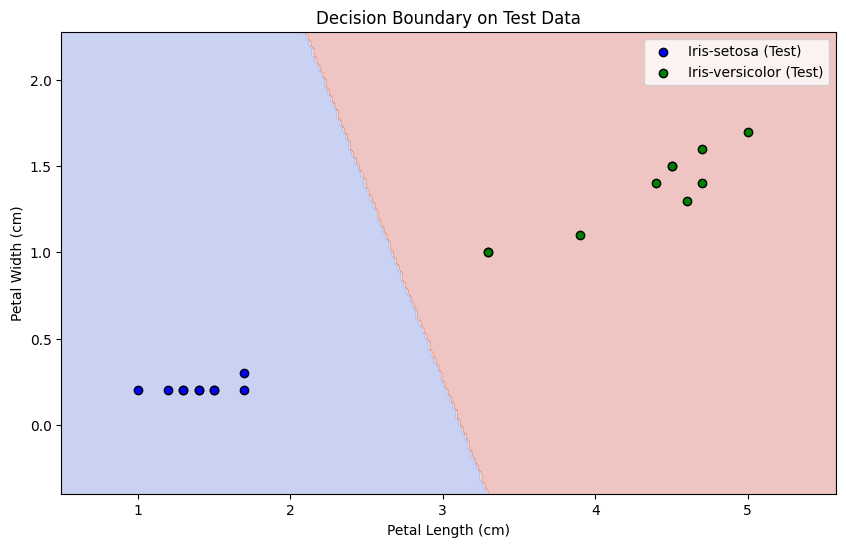

In [18]:
# Create a meshgrid to plot the decision boundary
feature_x_idx, feature_y_idx = 2, 3 # Using Petal Length and Petal Width
x_min, x_max = X[:, feature_x_idx].min() - 0.5, X[:, feature_x_idx].max() + 0.5
y_min, y_max = X[:, feature_y_idx].min() - 0.5, X[:, feature_y_idx].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# For each point in the meshgrid, we create a 4D feature vector,
# holding the other two features constant at their mean value.
grid_points = np.c_[xx.ravel(), yy.ravel()]
X_grid = np.full((grid_points.shape[0], 4), X_train.mean(axis=0))
X_grid[:, feature_x_idx] = grid_points[:, 0]
X_grid[:, feature_y_idx] = grid_points[:, 1]


# Make predictions on the entire grid
Z = np.array(model.predict(X_grid))
Z = Z.reshape(xx.shape)

# Plot the decision regions and the test data points
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Scatter plot the test data
plt.scatter(X_test[y_test == 0][:, feature_x_idx], X_test[y_test == 0][:, feature_y_idx],
            color='blue', label='Iris-setosa (Test)', edgecolor='k')
plt.scatter(X_test[y_test == 1][:, feature_x_idx], X_test[y_test == 1][:, feature_y_idx],
            color='green', label='Iris-versicolor (Test)', edgecolor='k')

plt.title('Decision Boundary on Test Data')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.legend()
plt.show()